In [1]:
import pandas as pd
import numpy as np
import torch

# Hardware Check

In [2]:
!nvidia-smi

Sun Nov  2 08:43:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:2B:00.0  On |                  N/A |
|  0%   29C    P8             17W /  170W |     484MiB /  12288MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
#check if GPU is available and print device name
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3060


# Dataset 

In [4]:
labels_df = pd.read_csv('labels.csv',names=['lat','lng','label1','label2','label3', 'filename'])

In [5]:
total_rows_len = len(labels_df)
print(f"\nTotal number of rows: {total_rows_len}")
labels_df.head()


Total number of rows: 2178


,lat,lng,label1,label2,label3,filename
0,10.328221,-20.476357,FR II,NaN,NaN,NaN
1,92.109802,-49.431413,typical,NaN,NaN,NaN
2,88.916825,-59.431868,Point Source,NaN,NaN,NaN
3,5.457981,-25.589637,FR II,NaN,NaN,NaN
4,119.417608,-53.396711,FR II,NaN,NaN,NaN


In [6]:

import os

#concatenate the directory to the filenames
filenames = ['Data/typ/typ_PNG/' + f for f in os.listdir('Data/typ/typ_PNG')] + ['Data/exo/exo_PNG/' + f for f in os.listdir('Data/exo/exo_PNG')]
print(f"Total number of files: {len(filenames)}")

# Print first 5 filenames
for i in range(5):
    print(filenames[i])

Total number of files: 2108
Data/typ/typ_PNG/0.250 -25.084_[0.02238656 0.02238656] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
Data/typ/typ_PNG/0.316 -24.707_[0.0166409 0.0166409] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
Data/typ/typ_PNG/0.327 -24.571_[0.02705031 0.02705031] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
Data/typ/typ_PNG/0.371 -24.554_[0.009 0.009] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
Data/typ/typ_PNG/0.425 -25.211_[0.02334787 0.02334787] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png


In [7]:
print(labels_df.dtypes)

lat         float64
lng         float64
label1       object
label2       object
label3       object
filename    float64
dtype: object


## Image to Label mapping

In [8]:
for i, filename in enumerate(filenames,start=0):
    #drop the directory path
    truncated_filename = os.path.basename(filename)
    coordinates = truncated_filename.split('_')[0]
    if coordinates.count(' ') != 1:
        print(f"Skipping filename with unexpected format: {truncated_filename}")
        continue
    
    lat, lng = coordinates.split(' ')
    lat, lng = float(lat), float(lng)
   
    label_row = labels_df[(labels_df['lat'].round(3) == lat) & (labels_df['lng'].round(3) == lng)]
    if not label_row.empty:
        labels_df.loc[label_row.index, 'filename'] = filename

C:\Users\User\AppData\Local\Temp\ipykernel_25944\1551268953.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Data/typ/typ_PNG/0.250 -25.084_[0.02238656 0.02238656] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  labels_df.loc[label_row.index, 'filename'] = filename


Skipping filename with unexpected format: .ipynb_checkpoints


In [9]:
def label_to_image_mapper(folder, labels_df):
    
    new_df = pd.DataFrame(columns=labels_df.columns)
    # print(f'{folder}/typ/typ_PNG/')
    filenames = [f'{folder}/typ/typ_PNG/' + f for f in os.listdir(f'{folder}/typ/typ_PNG')] + [f'{folder}/exo/exo_PNG/' + f for f in os.listdir(f'{folder}/exo/exo_PNG')]
    print(f"Total number of files: {len(filenames)}")

    # Print first 5 filenames
    for i in range(1):
        print(filenames[i])

    for i, filename in enumerate(filenames,start=0):
        #drop the directory path
        truncated_filename = os.path.basename(filename)
        coordinates = truncated_filename.split('_')[0]
        
        if coordinates.count(' ') != 1:
            print(f"Skipping filename with unexpected format: {truncated_filename}")
            continue
        
        lat, lng = coordinates.split(' ')
        lat, lng = float(lat), float(lng)
    
        label_row = labels_df[(labels_df['lat'].round(3) == lat) & (labels_df['lng'].round(3) == lng)]
        if not label_row.empty:
            #insert row to new dataframe
            new_row = label_row.copy()
            new_row['filename'] = filename
            new_df = pd.concat([new_df, new_row], ignore_index=True)

    return new_df

In [10]:
labels_df.head()

,lat,lng,label1,label2,label3,filename
0,10.328221,-20.476357,FR II,NaN,NaN,Data/typ/typ_PNG/10.328 -20.476_[0.01424399 0....
1,92.109802,-49.431413,typical,NaN,NaN,Data/typ/typ_PNG/92.110 -49.431_[0.04121882 0....
2,88.916825,-59.431868,Point Source,NaN,NaN,Data/typ/typ_PNG/88.917 -59.432_[0.009 0.009] ...
3,5.457981,-25.589637,FR II,NaN,NaN,Data/typ/typ_PNG/5.458 -25.590_[0.009 0.009] d...
4,119.417608,-53.396711,FR II,NaN,NaN,Data/typ/typ_PNG/119.418 -53.397_[0.009 0.009]...


## Missed labels

In [11]:
missed_labels_df = labels_df[labels_df['filename'].isnull()]
print(f"\nNumber of missed labels (filename is null): {len(missed_labels_df)}")
missed_labels_df.head()


Number of missed labels (filename is null): 202


,lat,lng,label1,label2,label3,filename
8,351.664270,-40.441765,Should be discarded,NaN,NaN,NaN
10,3.751163,-29.920867,Should be discarded,NaN,NaN,NaN
18,172.646749,-41.932433,Should be discarded,NaN,NaN,NaN
20,97.471185,-56.563903,Should be discarded,NaN,NaN,NaN
23,61.156721,-71.298579,Should be discarded,NaN,NaN,NaN


In [12]:
missed_labels_df['label1'].value_counts()

label1
Should be discarded    130
Point Source            45
FR II                   14
Bent                     8
FR I                     5
Name: count, dtype: int64

In [13]:
labels_df['label1'].value_counts()

label1
FR II                  683
Point Source           442
FR I                   431
Bent                   428
Should be discarded    130
typical                 24
Exotic                  18
S/Z shaped              17
X-Shaped                 5
Name: count, dtype: int64

In [14]:
labels_df['label2'].value_counts()

label2
Bent                   97
Should be discarded    69
Exotic                 33
S/Z shaped              4
X-Shaped                1
Name: count, dtype: int64

In [15]:
labels_df['label3'].value_counts()

label3
Exotic                 5
Should be discarded    1
Name: count, dtype: int64

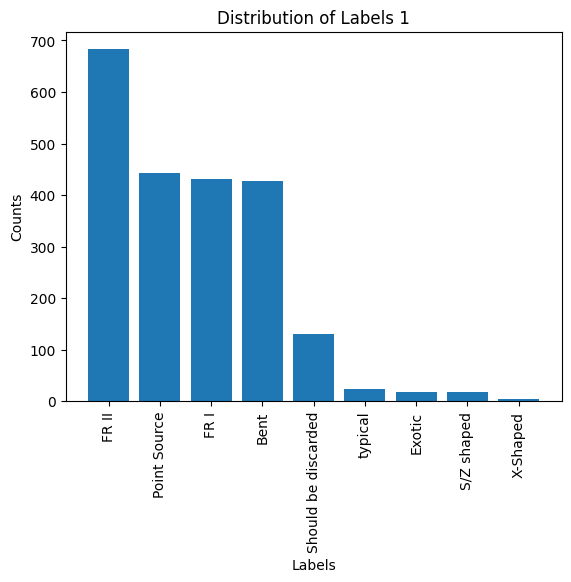

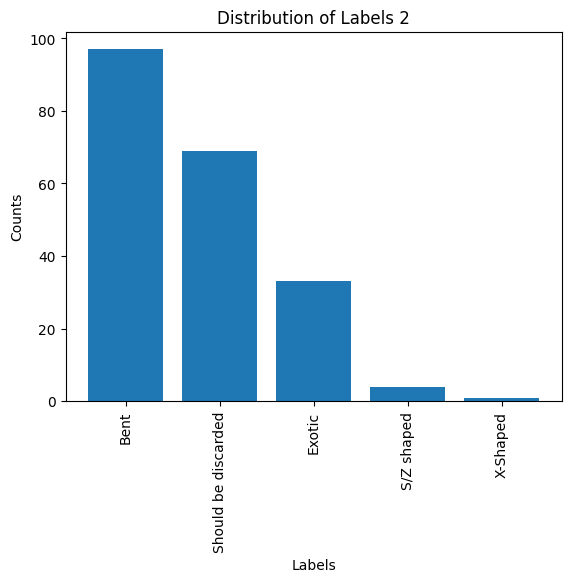

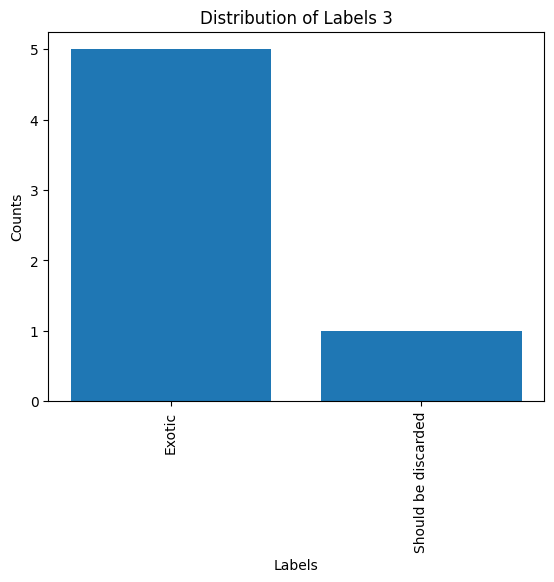

In [16]:
#plot a bar chart of the label1 value counts
import matplotlib.pyplot as plt

for i in range(len(['label1','label2','label3'])):
    label_counts = labels_df[f'label{i+1}'].value_counts()
    plt.bar(label_counts.index, label_counts.values)
    plt.xticks(rotation=90)
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(f'Distribution of Labels {i+1}')
    plt.show()

## Collapsed Labels

In [17]:
def collapse_labels(labels_df):
    collapsed_df = labels_df.melt(
        id_vars=['lat', 'lng', 'filename'],
        value_vars=['label1', 'label2', 'label3'],
        var_name='label_type',
        value_name='label'
    )
    collapsed_df.drop(columns=['label_type'], inplace=True)
    collapsed_df.dropna(subset=['label'], inplace=True)
    collapsed_df.reset_index(drop=True, inplace=True)


    return collapsed_df

In [18]:

collapsed_label_df = collapse_labels(labels_df)
collapsed_label_df.dropna(subset=['filename'], inplace=True)
print(f"\nTotal number of rows: {len(collapsed_label_df)}")
collapsed_label_df.head()




Total number of rows: 2118


,lat,lng,filename,label
0,10.328221,-20.476357,Data/typ/typ_PNG/10.328 -20.476_[0.01424399 0....,FR II
1,92.109802,-49.431413,Data/typ/typ_PNG/92.110 -49.431_[0.04121882 0....,typical
2,88.916825,-59.431868,Data/typ/typ_PNG/88.917 -59.432_[0.009 0.009] ...,Point Source
3,5.457981,-25.589637,Data/typ/typ_PNG/5.458 -25.590_[0.009 0.009] d...,FR II
4,119.417608,-53.396711,Data/typ/typ_PNG/119.418 -53.397_[0.009 0.009]...,FR II


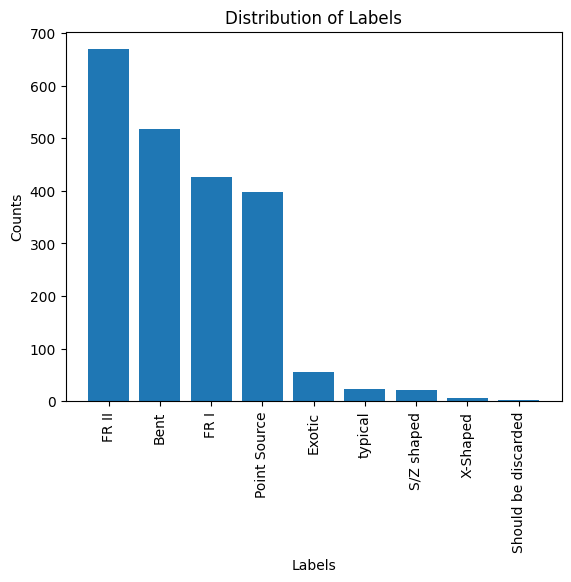

In [19]:
#plot a bar chart of the label1 value counts
import matplotlib.pyplot as plt

label_counts = collapsed_label_df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title(f'Distribution of Labels')
plt.show()


Label: FR II


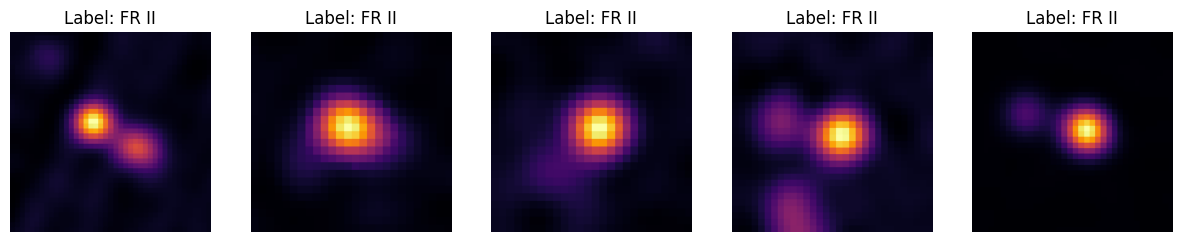


Label: typical


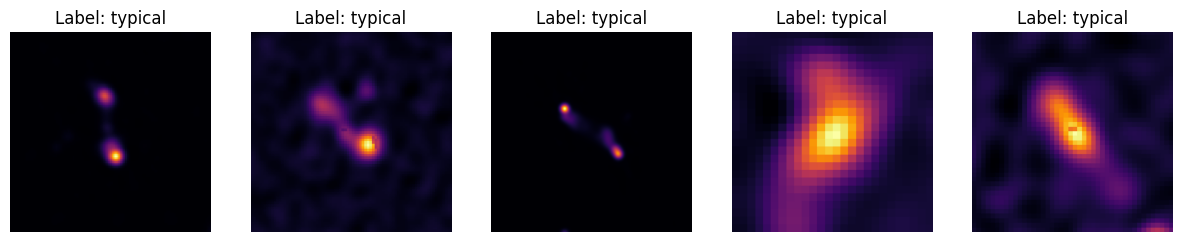


Label: Point Source


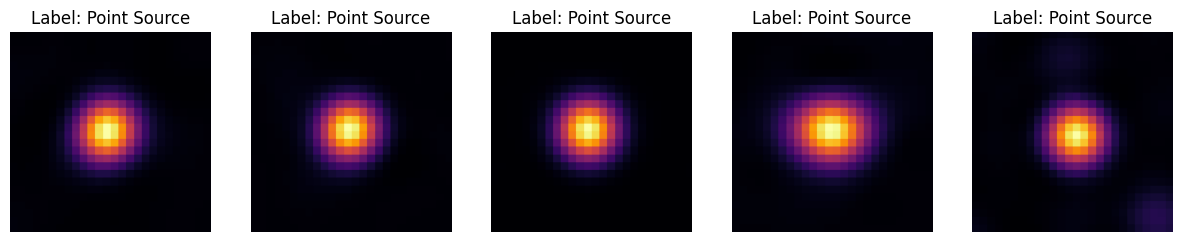


Label: Bent


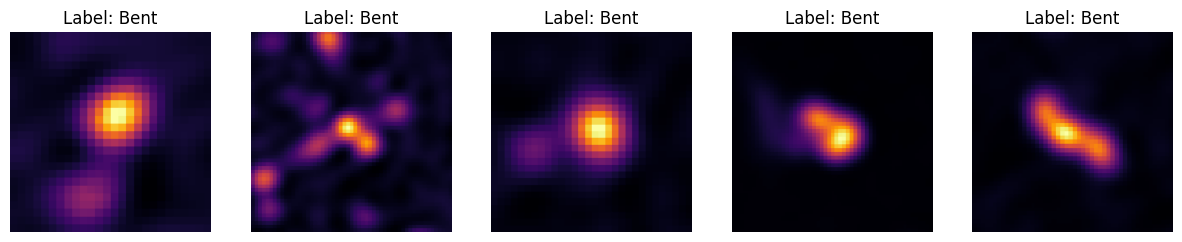


Label: FR I


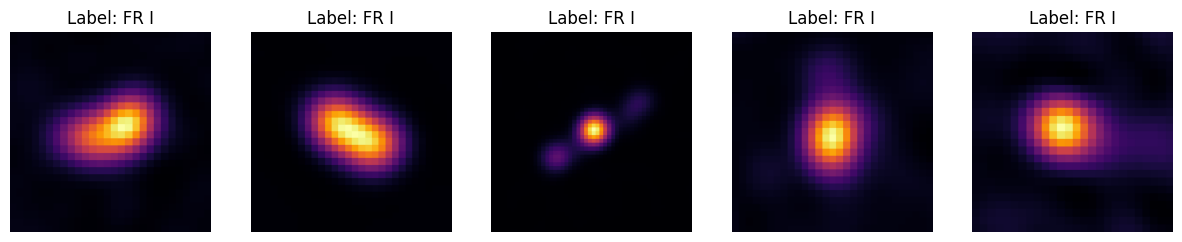


Label: Exotic


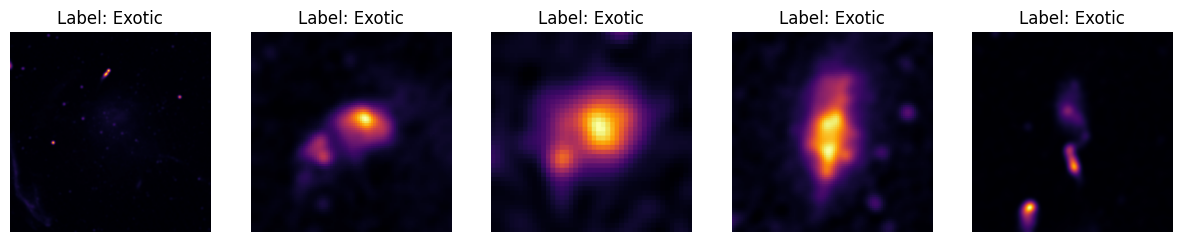


Label: S/Z shaped


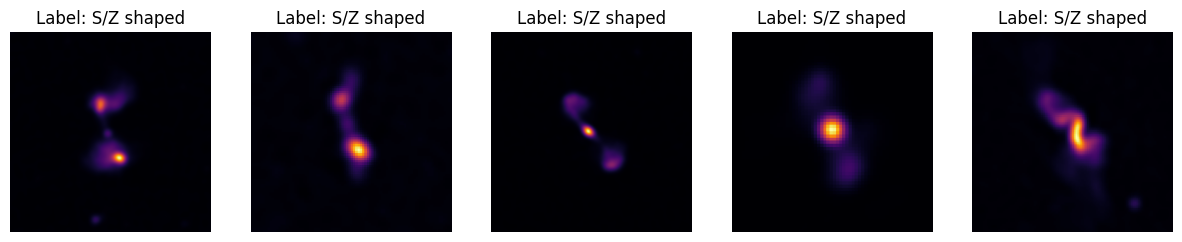


Label: X-Shaped


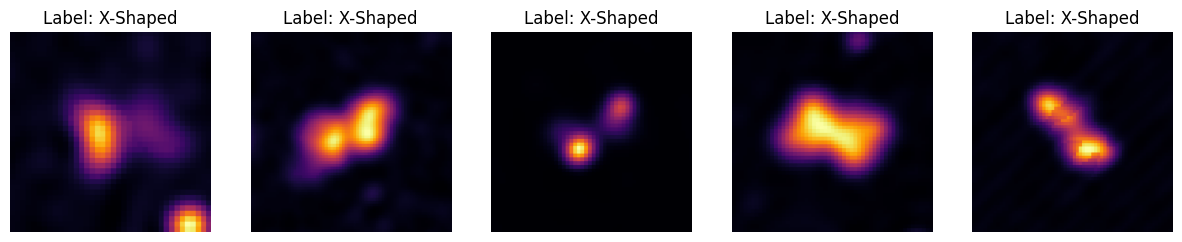


Label: Should be discarded


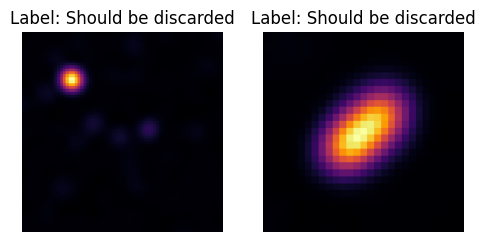

In [20]:
# print 5 images from each label category in label1
import matplotlib.image as mpimg
unique_labels = collapsed_label_df['label'].unique()
for label in unique_labels:
    label_filenames = collapsed_label_df[collapsed_label_df['label'] == label]['filename'].dropna().tolist()
    print(f"\nLabel: {label}")
    # print the files in one row
    plt.figure(figsize=(15, 5))
    for i, filename in enumerate(label_filenames[:5]):
        img = mpimg.imread(filename)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Label: {label}")

    
    plt.show()

In [21]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [22]:
# Define augmentation pipeline for training data
train_transform = transforms.Compose([
    transforms.ToTensor(),              # Convert image to PyTorch tensor
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(15),     # Randomly rotate by +/- 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate
])

In [23]:
output_dir_typ = 'Augmented_Data/typ/typ_PNG'
output_dir_exo = 'Augmented_Data/exo/exo_PNG'

os.makedirs(output_dir_typ, exist_ok=True)
os.makedirs(output_dir_exo, exist_ok=True)

In [24]:
#check if path exists and if is empty
if os.path.exists(output_dir_typ):
    print(f"Directory {output_dir_typ} exists.")
    if not os.listdir(output_dir_typ):
        print(f"Directory {output_dir_typ} is empty.")
    else:
        print(f"Directory {output_dir_typ} is not empty.")

if os.path.exists(output_dir_exo):
    print(f"Directory {output_dir_exo} exists.")
    if not os.listdir(output_dir_exo):
        print(f"Directory {output_dir_exo} is empty.")
    else:
        print(f"Directory {output_dir_exo} is not empty.")

Directory Augmented_Data/typ/typ_PNG exists.
Directory Augmented_Data/typ/typ_PNG is not empty.
Directory Augmented_Data/exo/exo_PNG exists.
Directory Augmented_Data/exo/exo_PNG is not empty.


## Generate new images

In [25]:
from PIL import Image, ImageOps
from torchvision.transforms.functional import to_pil_image

# Loop through each image and apply augmentations
num_augmentations = 5
# print(dataset.datasets)

images = labels_df['filename'].dropna().tolist()
for image in images:
    original_img = Image.open(image).convert('RGB')
    truncated_filename = os.path.basename(image)
    coordinates = truncated_filename.split('_')[0]
    
    full_save_path = None
    folder = 'Augmented_Data'
    subfolder = ''
    category = ''
    
    if 'typ' in image:
        subfolder = 'typ'
        category = 'typ_PNG'
    elif 'exo' in image:
        subfolder = 'exo'
        category = 'exo_PNG'
    

    
    for i in range(num_augmentations+1):
        
        augmented_img = None
        # add original image as first image resized to 224x224
        if i==0:
            augmented_img = transforms.Resize((224, 224))(transforms.ToTensor()(original_img))
        else:
            augmented_img = train_transform(original_img)
        
        new_filename = f"{coordinates}_aug_{i+1}.png"
        # Determine output directory based on dataset root
        # Save only if not already present
        full_save_path = os.path.join(folder, subfolder, category, new_filename)
        #save empty text file
       
        # Make sure the parent directories exist
        os.makedirs(os.path.dirname(full_save_path), exist_ok=True)

        # Check if the file exists before saving
        if not os.path.exists(full_save_path):
            # Convert tensor to PIL Image and save as PNG
            pil_img = to_pil_image(augmented_img)
            pil_img.save(full_save_path)
            print("✅ Augmented image saved to:", full_save_path)
        else:
            print(f"File already exists: {full_save_path}")

File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_1.png
File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_2.png
File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_3.png
File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_4.png
File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_5.png
File already exists: Augmented_Data\typ\typ_PNG\10.328 -20.476_aug_6.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_1.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_2.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_3.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_4.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_5.png
File already exists: Augmented_Data\typ\typ_PNG\92.110 -49.431_aug_6.png
File already exists: Augmented_Data\typ\typ_PNG\88.917 -59.432_aug_1.png
File already exists: Augmented_Data\typ\typ_PNG\88.

In [26]:
augmented_img_df = label_to_image_mapper('Augmented_Data', labels_df)
collapsed_augmented_label_df = collapse_labels(augmented_img_df)

Total number of files: 11760
Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_1.png


C:\Users\User\AppData\Local\Temp\ipykernel_25944\3247669299.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, new_row], ignore_index=True)


In [27]:
collapsed_augmented_label_df.head()

,lat,lng,filename,label
0,0.250419,-25.084203,Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_1...,FR II
1,0.250419,-25.084203,Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_2...,FR II
2,0.250419,-25.084203,Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_3...,FR II
3,0.250419,-25.084203,Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_4...,FR II
4,0.250419,-25.084203,Augmented_Data/typ/typ_PNG/0.250 -25.084_aug_5...,FR II


In [28]:
collapsed_label_df['numerical_label'] = collapsed_label_df['label'].astype('category').cat.codes

collapsed_label_df[['label', 'numerical_label']].value_counts().sort_index(level='numerical_label')

# Create a dictionary with numerical labels as keys and original labels as values


label                numerical_label
Bent                 0                  517
Exotic               1                   56
FR I                 2                  426
FR II                3                  669
Point Source         4                  397
S/Z shaped           5                   21
Should be discarded  6                    2
X-Shaped             7                    6
typical              8                   24
Name: count, dtype: int64

In [29]:
# convert labels in collapsed_augmented_label_df to numerical labels


collapsed_augmented_label_df['numerical_label'] = collapsed_augmented_label_df['label'].astype('category').cat.codes

collapsed_augmented_label_df[['label', 'numerical_label']].value_counts().sort_index(level='numerical_label')


# Create a dictionary with numerical labels as keys and original labels as values


label                numerical_label
Bent                 0                  3102
Exotic               1                   336
FR I                 2                  2556
FR II                3                  4014
Point Source         4                  2382
S/Z shaped           5                   126
Should be discarded  6                    12
X-Shaped             7                    36
typical              8                   144
Name: count, dtype: int64

In [30]:
numerical_label_dict = dict(zip(
    collapsed_augmented_label_df['numerical_label'],
    collapsed_augmented_label_df['label']
))

# # numerical_label_dict = dict(zip(
# #     collapsed_label_df['numerical_label'],
# #     collapsed_label_df['label']
# # ))

numerical_label_dict

{3: 'FR II',
 0: 'Bent',
 2: 'FR I',
 8: 'typical',
 4: 'Point Source',
 7: 'X-Shaped',
 5: 'S/Z shaped',
 1: 'Exotic',
 6: 'Should be discarded'}

# Models

## load train test set

In [31]:
from sklearn.model_selection import train_test_split

def dataset_split(image_df):
    image_files = image_df['filename'].dropna().tolist()
    labels = image_df['numerical_label'].dropna().tolist()

    print(f"Total number of images: {len(image_files)}")
    print(f"Total number of labels: {len(labels)}")
    images = []

    for file in image_files:
        img = Image.open(file).convert("L")
        # img = ImageOps.invert(img)
        img = np.array(img) / 255.0 # normalize to [0,1]

        # img = transform(img)
        images.append(img)

    #print the images
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, idx in enumerate(np.random.randint(0, len(images), size=5)):
        axes[i].imshow(images[idx], cmap='gray')
        axes[i].axis('off')

    train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

    train_images = np.array(train_images)
    test_images = np.array(test_images)

    #print lengths of train and test sets
    print(f"Train set size: {len(train_images)}")
    print(f"Test set size: {len(test_images)}")


    print(np.unique(train_labels))

    train_dataset_mean = train_images.mean()
    train_dataset_std = train_images.std()

    print(f"Train dataset mean: {train_dataset_mean:.4f}")
    print(f"Train dataset std: {train_dataset_std:.4f}")

    

    return {
        'train_images': train_images,
        'test_images': test_images,
        'train_labels': train_labels,
        'test_labels': test_labels,
        'train_dataset_mean': train_dataset_mean,
        'train_dataset_std': train_dataset_std,
    }


## Custom dataset

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx]

        # If image is grayscale (H, W), convert to (1, H, W)
        # if image.ndim == 2:
        #     image = np.expand_dims(image, axis=0)
        # If image is (H, W, C), convert to (C, H, W)
        # elif image.ndim == 3 and image.shape[2] == 3:
        #     image = np.transpose(image, (2, 0, 1))

        #image = torch.from_numpy(image)

        if self.transform:
            image = self.transform(image)

        return image, label


## Train function

In [33]:
#Custome Early stop to help monitor training and the numbet of ephocs
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [34]:
import copy

def train(model, criterion, optimizer, loaded_dataset, best_model_state, epochs, early_stopping, scheduler):
    
    train_losses = []
    val_losses = []

    transform = transforms.Compose([
    # Convert (1, H, W) to (3, H, W) by repeating the channel
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    transforms.Normalize(mean=[loaded_dataset['train_dataset_mean']], std=[loaded_dataset['train_dataset_std']])
    ])

    # create datasets
    train_dataset = CustomDataset(loaded_dataset['train_images'], loaded_dataset['train_labels'], transform=transform)
    test_dataset = CustomDataset(loaded_dataset['test_images'], loaded_dataset['test_labels'], transform=transform)

    # create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    best_ave_loss = float('inf')

    print(f"Starting training for model: {model.name}")

    model.train()
    for epoch in range(epochs):
        ave_loss = 0.0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            ave_loss += loss.detach().cpu().numpy()
        
        ave_loss /= len(train_dataloader)
        train_losses.append(ave_loss)
        

        # Evaluation mode using dataloader
        model.eval()
        with torch.no_grad():
            ave_val_loss = 0.0
            for val_images, val_labels in test_dataloader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                scheduler.step(loss)

                ave_val_loss += loss.detach().cpu().numpy()
            
            ave_val_loss /= len(test_dataloader)
            val_losses.append(ave_val_loss)

        # if model.name == 'ResNet18':
        early_stopping.step(ave_loss)
        if ave_loss < best_ave_loss:
            best_ave_loss = ave_loss
            best_model_state = copy.deepcopy(model.state_dict())

        if early_stopping.early_stop:
            print(f"Early stop at epoch {epoch + 1}")
            break
            
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {ave_loss} Val Loss: {ave_val_loss}")
    
    # if model.name == 'ResNet18':
    model.load_state_dict(best_model_state)
    print()
    return model, train_losses, val_losses, test_dataloader

Total number of images: 2118
Total number of labels: 2118
Train set size: 1694
Test set size: 424
[0 1 2 3 4 5 6 7 8]
Train dataset mean: 0.0698
Train dataset std: 0.1492


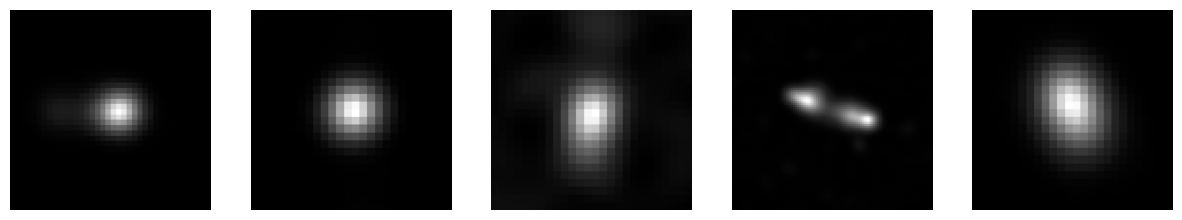

In [35]:
loaded_datasets = {}
loaded_datasets['data'] = dataset_split(collapsed_label_df)

Total number of images: 12708
Total number of labels: 12708
Train set size: 10166
Test set size: 2542
[0 1 2 3 4 5 6 7 8]
Train dataset mean: 0.0665
Train dataset std: 0.1478


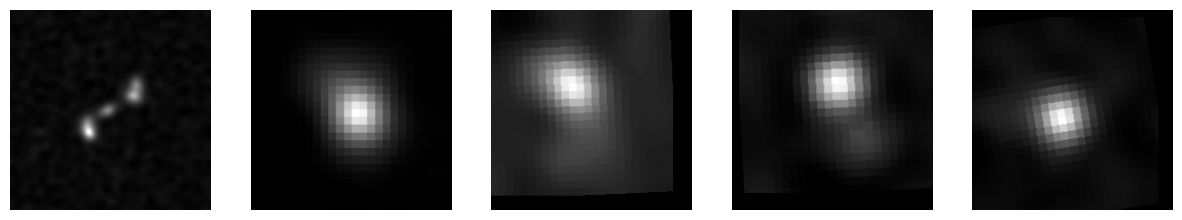

In [36]:
loaded_datasets['augmented_data'] = dataset_split(collapsed_augmented_label_df)

In [37]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
print(torch.cuda.memory_summary(device=None, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------

## VGG16

### model definition

In [38]:
def get_vgg16(numerical_label_dict):
    vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    vgg16.name = 'VGG16'

    for param in vgg16.features.parameters():
        param.requires_grad = False

    num_classes = len(numerical_label_dict)

    #modift the connv to accept single channel input
    vgg16.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5), #adjust accordingly to help with overfitting
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5), #adjust accordingly to help with overfitting
        nn.Linear(1024, num_classes)
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vgg16 = vgg16.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(vgg16.classifier.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # monitor the model and if the model stops learning it will stop the training
    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    return vgg16, criterion, optimizer, scheduler, early_stopping


    #print(vgg16)

### train model

In [39]:
epochs = 10
results_list = {}
for dataset_name, dataset in loaded_datasets.items():
    print(f"\nTraining on dataset: {dataset_name}")
    vgg16, criterion, optimizer, scheduler, early_stopping = get_vgg16(numerical_label_dict)
    trained_model, train_losses, val_losses, test_dataloader = train(vgg16, criterion, optimizer,dataset, copy.deepcopy(vgg16.state_dict()),epochs=epochs, early_stopping=early_stopping, scheduler=scheduler)

    results_list.setdefault(dataset_name, []).append({
            'model': trained_model,
            'model_name': 'VGG16',
            'dataset': dataset_name,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'test_dataloader': test_dataloader
        }
    )



Training on dataset: data
Starting training for model: VGG16
Epoch [1/10] Train Loss: 1.5543935298919678 Val Loss: 1.285379409790039
Epoch [2/10] Train Loss: 1.161363124847412 Val Loss: 1.2297747135162354
Epoch [3/10] Train Loss: 1.013312816619873 Val Loss: 1.1895227432250977
Epoch [4/10] Train Loss: 0.9456603527069092 Val Loss: 1.1966209411621094
Epoch [5/10] Train Loss: 0.913337230682373 Val Loss: 1.1967737674713135
Epoch [6/10] Train Loss: 0.9028139114379883 Val Loss: 1.1925665140151978
Epoch [7/10] Train Loss: 0.8988726139068604 Val Loss: 1.1916159391403198
Epoch [8/10] Train Loss: 0.8979824781417847 Val Loss: 1.1914787292480469
Epoch [9/10] Train Loss: 0.8981055617332458 Val Loss: 1.191482663154602
Epoch [10/10] Train Loss: 0.8978243470191956 Val Loss: 1.191486120223999


Training on dataset: augmented_data
Starting training for model: VGG16
Epoch [1/10] Train Loss: 1.4244489669799805 Val Loss: 1.2182886600494385
Epoch [2/10] Train Loss: 1.186322569847107 Val Loss: 1.217305660247

## RESNET 18

### model definition

In [40]:
def get_resnet18(numerical_label_dict):
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    resnet.name = 'ResNet18'
    # Freeze convolutional base
    for param in resnet.parameters():
        param.requires_grad = False

    # we unfreeze the top laryer so we can train from 
    # this is because our data/images are different from the data/images resnet18 was trained on
    for param in resnet.layer4.parameters():
        param.requires_grad = True

    num_classes = len(numerical_label_dict)

    resnet.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    resnet = resnet.to(device)

    criterion = nn.CrossEntropyLoss()
    #The filter only passes only the trainable parameter to the optimizer - saves computation time
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # monitor the model and if the model stops learning it will stop the training
    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    return resnet, criterion, optimizer, scheduler, early_stopping

### train model

In [41]:


epochs = 50
for dataset_name, dataset in loaded_datasets.items():
    print(f"\nTraining on dataset: {dataset_name}")
    resnet, criterion, optimizer, scheduler, early_stopping = get_resnet18(numerical_label_dict)
    trained_model, train_losses, val_losses, test_dataloader = train(resnet, criterion, optimizer, dataset, copy.deepcopy(resnet.state_dict()), epochs=epochs, early_stopping=early_stopping, scheduler=scheduler)
    results_list.setdefault(dataset_name, []).append({
            'model': trained_model,
            'model_name': 'ResNet18',
            'dataset': dataset_name,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'test_dataloader': test_dataloader
        }
    )



Training on dataset: data
Starting training for model: ResNet18
Epoch [1/50] Train Loss: 1.416561245918274 Val Loss: 1.3188940286636353
Epoch [2/50] Train Loss: 1.2329899072647095 Val Loss: 1.3225219249725342
Epoch [3/50] Train Loss: 1.146758794784546 Val Loss: 1.240709662437439
Epoch [4/50] Train Loss: 1.1190855503082275 Val Loss: 1.2444785833358765
Epoch [5/50] Train Loss: 1.1119019985198975 Val Loss: 1.2449020147323608
Epoch [6/50] Train Loss: 1.1112003326416016 Val Loss: 1.2449321746826172
Epoch [7/50] Train Loss: 1.1108911037445068 Val Loss: 1.2449429035186768
Epoch [8/50] Train Loss: 1.1113611459732056 Val Loss: 1.2449389696121216
Epoch [9/50] Train Loss: 1.1111812591552734 Val Loss: 1.2449400424957275
Epoch [10/50] Train Loss: 1.1108906269073486 Val Loss: 1.2449713945388794
Epoch [11/50] Train Loss: 1.110856294631958 Val Loss: 1.2449830770492554
Early stop at epoch 12


Training on dataset: augmented_data
Starting training for model: ResNet18
Epoch [1/50] Train Loss: 1.29915118

# Plots and Results

In [42]:
def plot_losses(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()
    plt.show()

In [43]:
from sklearn.metrics import classification_report
def print_model_performance(model, test_dataloader, numerical_label_dict):
    # evaluate the model on the test set with f1-score, precision and recall
    
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    #print classification report with numerical labels converted to original labels
    target_names = list(numerical_label_dict.values())
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, labels=list(numerical_label_dict.keys()), target_names=target_names, zero_division=0))
    report = classification_report(all_labels, all_preds, labels=list(numerical_label_dict.keys()), target_names=target_names, output_dict=True, zero_division=0)
    return report

In [44]:
def plot_results(report, model_name):
    # Plot precision, recall, and f1-score for each class
    labels = list(numerical_label_dict.values())
    precision = [report[label]['precision'] for label in labels]
    recall = [report[label]['recall'] for label in labels]
    f1_score = [report[label]['f1-score'] for label in labels]

    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1_score, width, label='F1-Score')

    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title(f'Precision, Recall, and F1-Score for {model_name}')
    plt.xticks(x, labels, rotation=90)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

Results for dataset: data
Model: VGG16


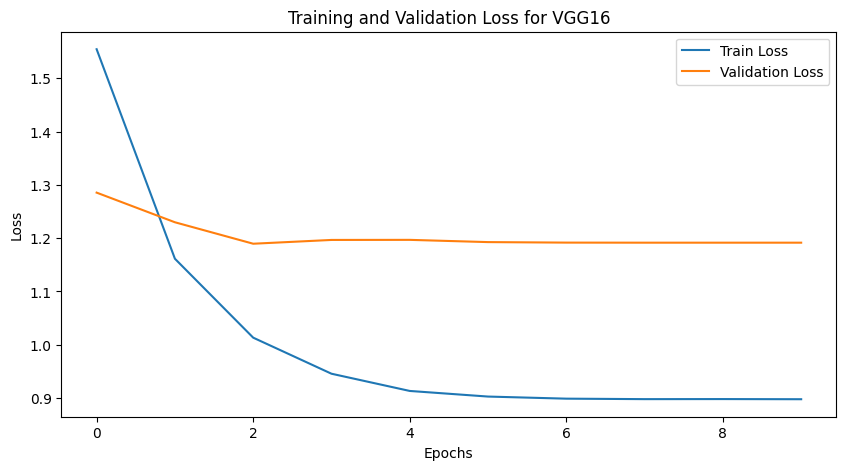

Classification Report:
                     precision    recall  f1-score   support

              FR II       0.61      0.62      0.62       134
               Bent       0.35      0.33      0.34       104
               FR I       0.37      0.40      0.39        85
            typical       0.00      0.00      0.00         5
       Point Source       0.69      0.80      0.74        80
           X-Shaped       0.00      0.00      0.00         1
         S/Z shaped       0.00      0.00      0.00         4
             Exotic       0.12      0.09      0.11        11
Should be discarded       0.00      0.00      0.00         0

           accuracy                           0.51       424
          macro avg       0.24      0.25      0.24       424
       weighted avg       0.49      0.51      0.50       424



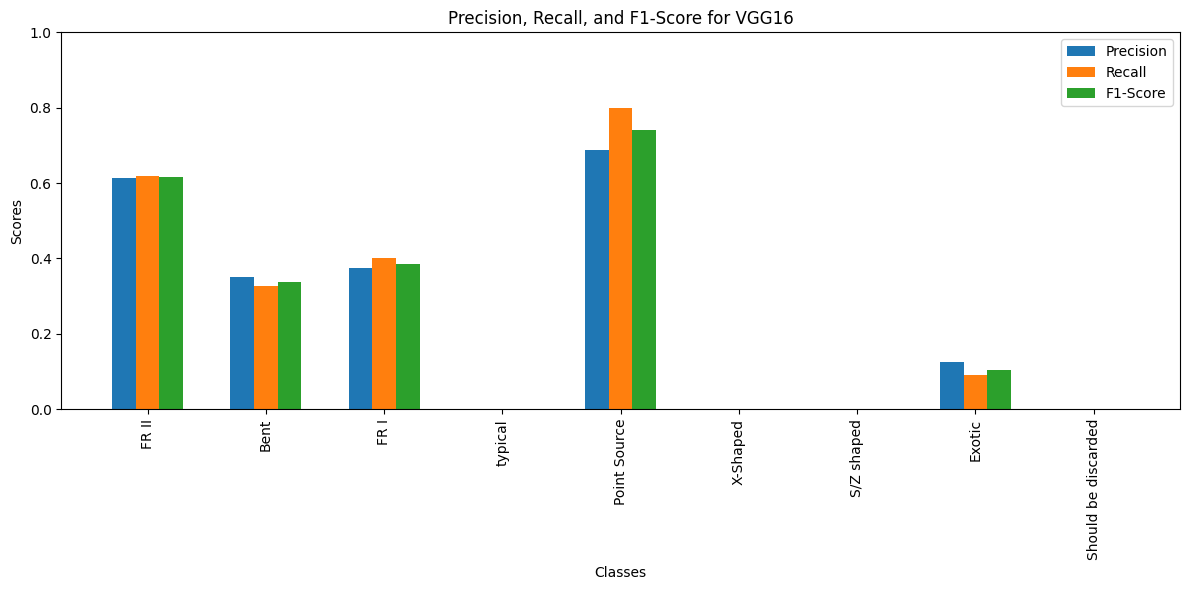

Model: ResNet18


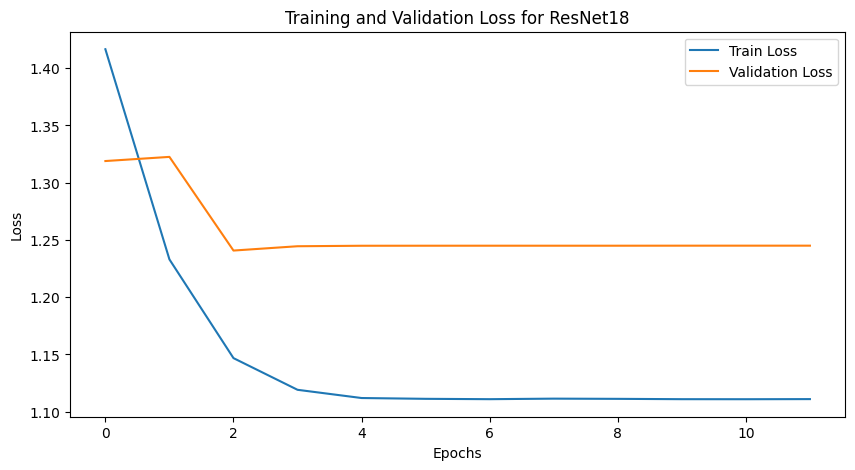

Classification Report:
                     precision    recall  f1-score   support

              FR II       0.50      0.72      0.59       134
               Bent       0.36      0.17      0.23       104
               FR I       0.36      0.34      0.35        85
            typical       0.00      0.00      0.00         5
       Point Source       0.65      0.74      0.69        80
           X-Shaped       0.00      0.00      0.00         1
         S/Z shaped       0.00      0.00      0.00         4
             Exotic       0.11      0.09      0.10        11
Should be discarded       0.00      0.00      0.00         0

           accuracy                           0.48       424
          macro avg       0.22      0.23      0.22       424
       weighted avg       0.44      0.48      0.45       424



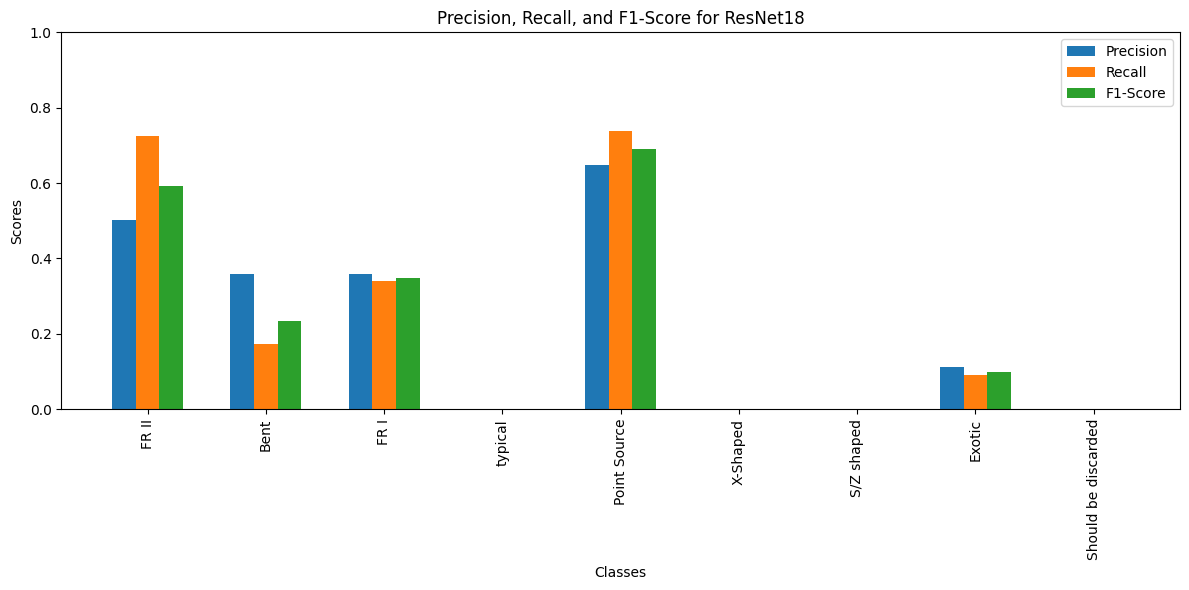

Results for dataset: augmented_data
Model: VGG16


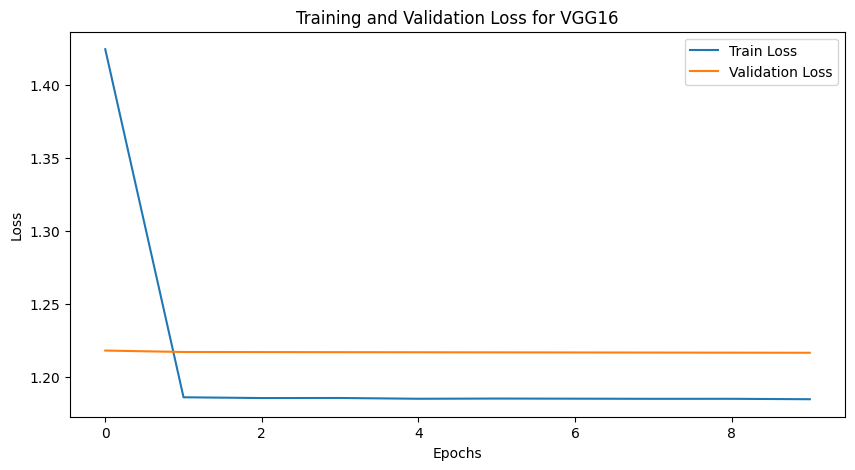

Classification Report:
                     precision    recall  f1-score   support

              FR II       0.48      0.79      0.59       803
               Bent       0.44      0.12      0.19       621
               FR I       0.38      0.30      0.33       511
            typical       0.00      0.00      0.00        29
       Point Source       0.62      0.74      0.67       477
           X-Shaped       0.00      0.00      0.00         7
         S/Z shaped       0.00      0.00      0.00        25
             Exotic       0.32      0.34      0.33        67
Should be discarded       0.00      0.00      0.00         2

           accuracy                           0.49      2542
          macro avg       0.25      0.25      0.24      2542
       weighted avg       0.46      0.49      0.44      2542



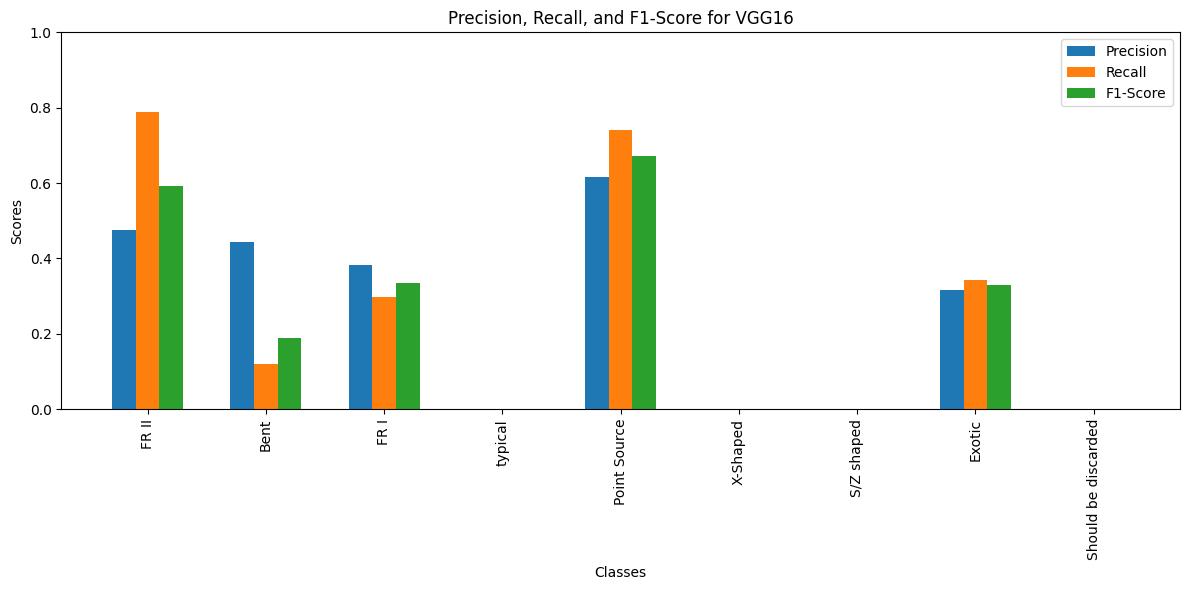

Model: ResNet18


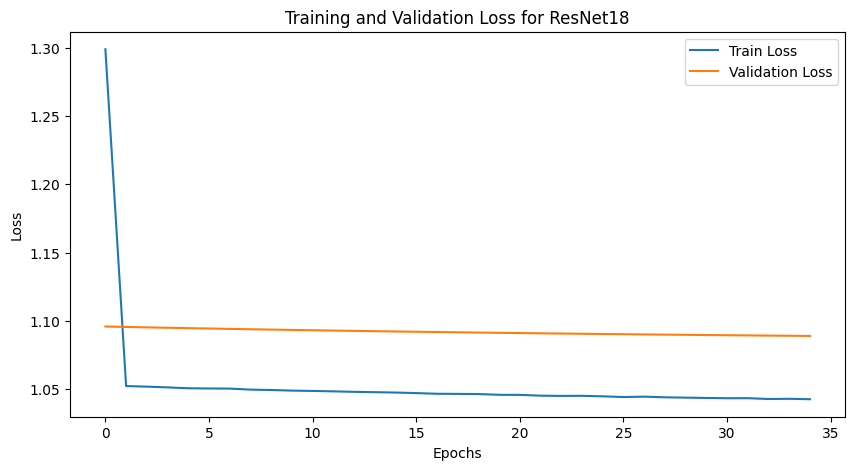

Classification Report:
                     precision    recall  f1-score   support

              FR II       0.61      0.75      0.67       803
               Bent       0.45      0.25      0.32       621
               FR I       0.44      0.54      0.49       511
            typical       0.00      0.00      0.00        29
       Point Source       0.67      0.73      0.70       477
           X-Shaped       0.00      0.00      0.00         7
         S/Z shaped       0.00      0.00      0.00        25
             Exotic       0.33      0.31      0.32        67
Should be discarded       0.00      0.00      0.00         2

           accuracy                           0.55      2542
          macro avg       0.28      0.29      0.28      2542
       weighted avg       0.53      0.55      0.53      2542



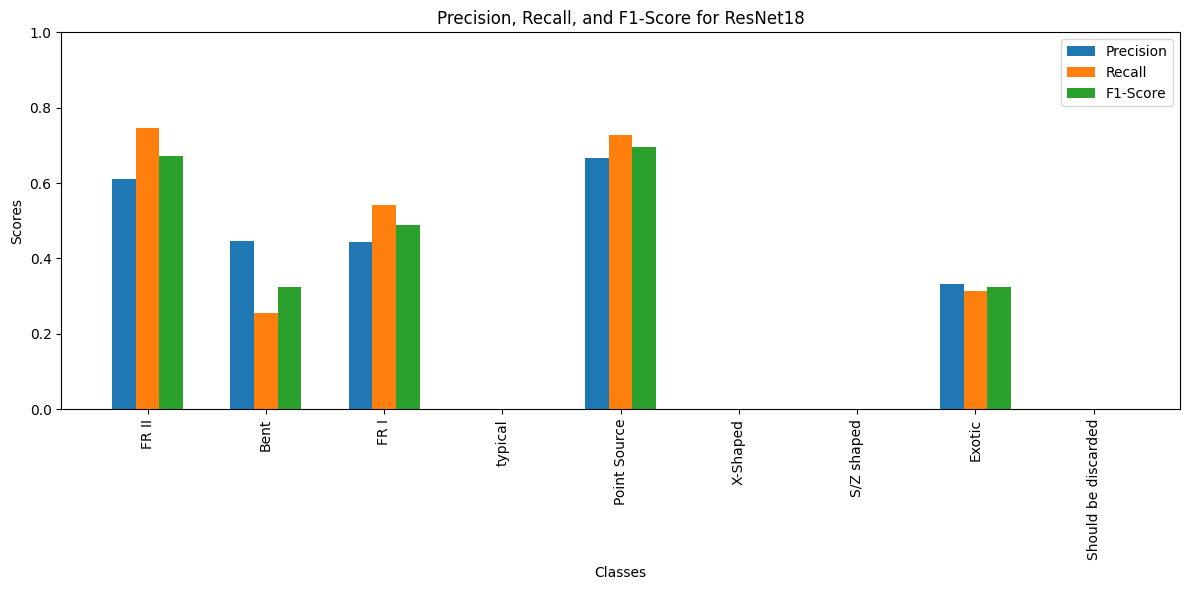

In [45]:
for k,v in results_list.items():
    print(f"Results for dataset: {k}")
    for result in v:
        print(f"Model: {result['model_name']}")
        model = result['model']
        model_name = result['model_name']
        train_losses = result['train_losses']
        val_losses = result['val_losses']
        test_dataloader = result['test_dataloader']

        plot_losses(train_losses, val_losses, model_name)
        report = print_model_performance(model, test_dataloader, numerical_label_dict)
        plot_results(report, model_name)